<h1 style="color:black" align="center">Предсказание цены на недвижимость</h1>

**Подлючение библиотек**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap


import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import train_test_split

# CatBoost
from catboost import CatBoostRegressor
from catboost import Pool

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

**Функции**

In [2]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10)) 
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

<h1 style="color:black" align="center">Загрузка Train набор данных для обучения модели</h1>

In [3]:
LOAD_PREPARED_DATASET_TRAIN = 'save_data/housing_prepared_train.csv'

In [4]:
train = pd.read_csv(LOAD_PREPARED_DATASET_TRAIN, index_col='Id')
train.head()

,Price,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,,
14038,184966.930730,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,1,1,33,7976,5,1144.0,0,11,1
15053,300009.450063,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,1,1,46,10309,1,240.0,1,16,1
4765,220925.908524,53,2.0,44.947953,29.197612,0.0,8,12.0,1968.0,0.049637,1,1,34,7759,0,229.0,1,3,1
5809,175616.227217,58,2.0,53.352981,52.731512,9.0,8,17.0,1977.0,0.437885,1,1,23,5735,3,1084.0,0,5,1
10783,150226.531644,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,1,1,35,5776,1,2078.0,2,4,1


### Подготовка данных к разбиению

Целевым значением для нас будет значение `"Price"` - Цена на недвижимость. Вынесем этот столбец в отдельную переменную `y`, а в переменную `X` запишем все столбцы из таблицы `df` кроме столбца `target`.

In [5]:
y = train['Price']
X = train.drop(['Price'], axis=1)

### Разбиение данных на тренировочный и тестовый DataSet

Обычно при обучении моделей машинного обучения используют две выборки: тренировочную и тестовую. Первая нужна для того, чтобы обучить модель. Вторая - для проверки качества обученной модели: мы можем сравнить предсказанную на этих данных цену с реальной, поскольку она у нас тоже имеется.

Разбиение данных на тренировочную и тестовую выборку можно выполнить с помощью функции `train_test_split` из модуля `sklearn.model_selection`.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=42)

## `CatBoost`

In [7]:
train_pool = Pool(data=X_train,
                     label=y_train)

valid_pool = Pool(data=X_valid,
                    label=y_valid)

model = CatBoostRegressor(iterations=10000,
                           grow_policy="Depthwise",
                           loss_function = 'RMSE',
                           eval_metric = 'R2',
                           early_stopping_rounds = 500,
#                            task_type="GPU", # закомментировать, если не на GPU
                           devices='0', # закомментировать, если не на GPU
                           verbose = False,
                           use_best_model=True)

# Fit model
model.fit(train_pool, eval_set=valid_pool, logging_level='Silent', plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<img src='img/Catboost.png'>

In [8]:
%%time
shap_values = model.get_feature_importance(
    data=train_pool, 
    type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

print(shap_values.shape)

(7000, 18)
Wall time: 1min 31s


## Оценка влияния признаков

Используя библиотеку shap можно оценить влиние признаков на предсказание. Данный график показывает, насколько данный конкретный признак изменил наше предсказание (по сравнению с тем, как мы сделали бы это предсказание при некотором базовом значении этого признака). 

### `Индивидуальная сила сюжета`


В приведенных ниже графиках показаны признаки, каждый из которых способствует продвижению выходных данных модели из базового значения (средний выход модели по переданному набору обучающих данных) в выходные данные модели. Признаки, которые подталкивают прогноз выше, показаны красным, а те, которые подталкивают прогноз ниже, - синим.

In [9]:
shap.initjs()
shap.force_plot(expected_value, shap_values[1,:], X_train.iloc[1,:]) 

Я произвольно выбрал 20-е наблюдение за данными X_train. Ниже приведены средние значения X_train и значения 20-го наблюдения.

In [10]:
pd.DataFrame({'Mean': X_train.mean(), 'Object': X_train.iloc[20,:]})

,Mean,Object
DistrictId,50.560857,62.000000
Rooms,1.913286,3.000000
Square,56.256581,104.446306
LifeSquare,37.661181,72.296950
KitchenSquare,5.885797,1.000000
Floor,7.908286,12.000000
HouseFloor,13.554138,15.000000
HouseYear,1984.918429,2015.000000
Ecology_1,0.117840,0.072158
Ecology_2,0.990857,1.000000


In [11]:
shap.force_plot(expected_value, shap_values[20,:], X_train.iloc[20,:])

Базовая стоимость: базовое значение (y_hat) - это «значение, которое было бы предсказано, если бы мы не знали каких-либо особенностей для текущего результата». Другими словами, это среднее предсказание или среднее значение (yhat). Среднее значение прогноза y_train составляет 2.145e+5.

`Square`: положительно влияет на стоимость недвижимости. Площадь этого дома составляет 104,4, что выше среднего значения 56.26. Так что это подталкивает прогноз вправо.

In [12]:
y_train.mean()

214449.1673897029

### `Краткий сюжет`

Одна точка на графике соответствует одному объекту. По горизонтальной оси можно наблюдать shap values, значение больше нуля говорит о том, что предсказание смешается больше в правую сторону и наоборот. Цвет показывает, является ли эта переменная высокой (красным) или низкой (синим) для данного наблюдения.

`Square:` наблюдаем что большое значение площади (красный цвет) сдвигает значение предсказания в правую сторону, тогда и значение целевой переменной будет больше, что логично. Тем самым можно оценить влияние признака на предсказания модели.

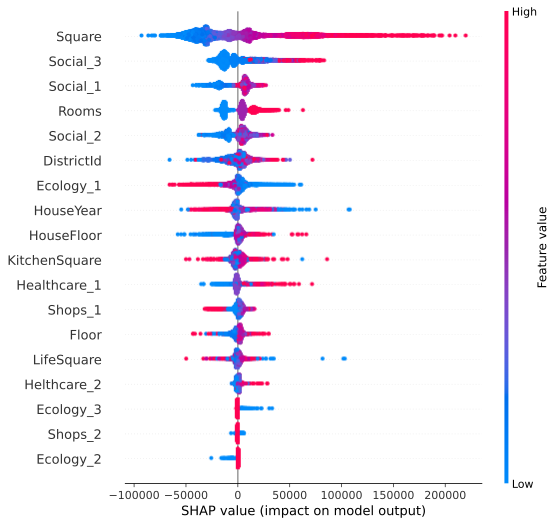

In [13]:
shap.summary_plot(shap_values, X_train)

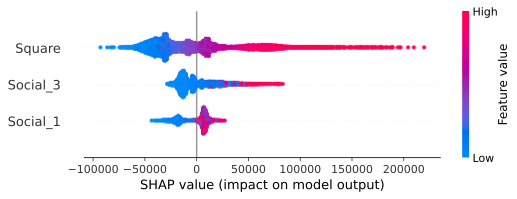

In [14]:
shap.summary_plot(shap_values, X_train, max_display=3)

### `Зависимость участка`

График частичной зависимостиили сокращение от графика зависимости, является важным графиком в результатах машинного обучения (Дж. Х. Фридман 2001). Он показывает предельное влияние, которое одна или две переменные оказывают на прогнозируемый результат. Он сообщает, является ли взаимосвязь между целью и переменной линейной, монотонной или более сложной. Предположим, мы хотим получить зависимость от «Square». Модуль Python SHAP автоматически включает в себя еще одну переменную, с которой «площадь» взаимодействует больше всего. Следующий график показывает, что между «Square» и целевой переменной существует линейная и положительная тенденция, и «Square» часто взаимодействует с «DistrictId».

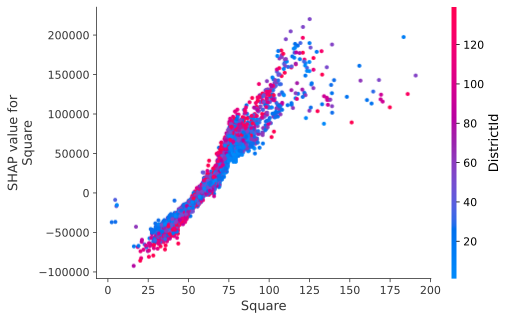

In [15]:
shap.dependence_plot("Square", shap_values, X_train)

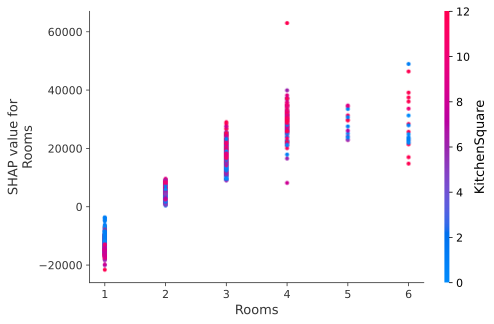

In [16]:
shap.dependence_plot("Rooms", shap_values, X_train)

## Оценка эффективности параметров

In [17]:
model.best_score_

{'learn': {'R2': 0.9261985208062319, 'RMSE': 25242.54500157202},
 'validation': {'R2': 0.7454651212321781, 'RMSE': 46791.52363545582}}

In [28]:
%config InlineBackend.figure_format = 'jpg'

R2:	0.913
MAE:	17732.843
MSE:	753675401.319


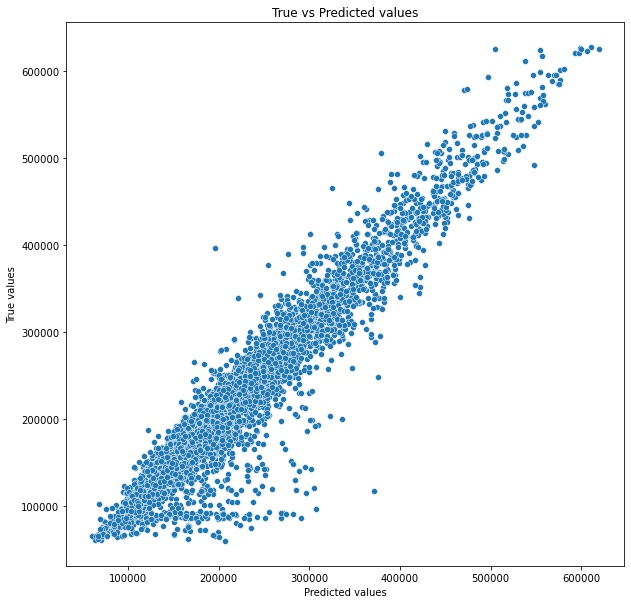

In [29]:
y_train_preds = model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.745
MAE:	26616.169
MSE:	2189446676.648


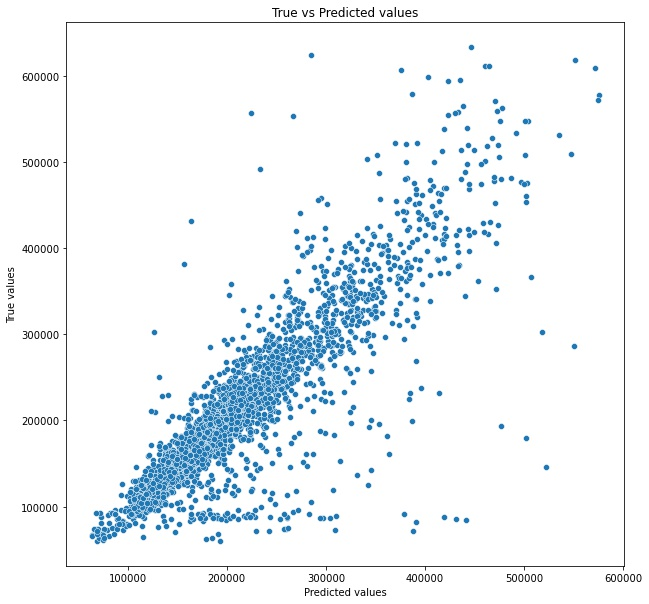

In [30]:
y_test_preds = model.predict(X_valid)
evaluate_preds(y_valid, y_test_preds)

**Оценка влияния признаков на результат модели**

In [20]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Square,34.964626
1,Rooms,13.266252
2,Social_2,9.077015
3,Social_3,8.255081
4,Social_1,7.764887
5,DistrictId,5.366916
6,Ecology_1,4.313048
7,KitchenSquare,2.958397
8,HouseYear,2.904508
9,LifeSquare,2.254406


<h1 style="color:black" align="center">Загрузка Test набор данных для предсказания цены</h1>

In [23]:
LOAD_PREPARED_DATASET_TEST = 'save_data/housing_prepared_test.csv'
SAVE_RESULT = 'Save_data/sample_submission.csv'

In [24]:
test = pd.read_csv(LOAD_PREPARED_DATASET_TEST, index_col='Id').drop(['Price'], axis=1)
test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972.0,0.310199,1,1,11,2748,1,1144.0,0,0,1
15856,74,2.0,69.263183,47.943457,1.0,1,6.0,1977.0,0.075779,1,1,6,1437,3,1144.0,0,2,1
5480,190,1.0,15.948246,13.597819,12.0,2,5.0,1909.0,0.000000,1,1,30,7538,87,4702.0,5,5,1
15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007.0,0.101872,1,1,23,4583,3,1144.0,3,3,1
14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017.0,0.072158,1,1,2,629,1,1144.0,0,0,0


### Предсказание цены с использованием самой лучшей модели

**Создание DataFrame для загрузки на Kaggle**

In [25]:
output = pd.DataFrame({'Id': test.index,
                       'Price': model.predict(test)})
output.head()

,Id,Price
0,725,159419.305429
1,15856,214372.137469
2,5480,189764.214555
3,15664,345435.860098
4,14275,147384.452147


### Сохранение результатов

In [26]:
output.to_csv(SAVE_RESULT, index=False, encoding='utf-8')